## Exporting NCrystal materials to ENDF and use them in OpenMC

In this notebook we show how to export ENDF files from NCrystal, process them into ACE files using NJOY and running simulations in OpenMC. These simulations can compare the use of exported ENDF files from NCrystal in OpenMC, with the on-the-fly simulation of thermal scattering in OpenMC using NCrystal.

## Preamble: install NCrystal, NJOY, OpenMC and nuclear data

Install OpenMC, NJOY2016, NCrystal and endf-parserpy from conda-forge using mamba, and download NNDC from OpenMC repo. The conversion script endf2ace is downloaded from ESS Gitlab. Feel free to edit as you wish:

In [1]:
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if google_colab:
    print("WARNING: Installing mambaforge. This will cause your notebook "
          "to say it crashed and restart itself. This is expected behaviour!!")
    %pip -q install condacolab
    import condacolab
    condacolab.install_miniforge()
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab

import pathlib
import os
import shutil
import subprocess
if not shutil.which('openmc') or not shutil.which('nctool') or not shutil.which('njoy'):
    if not google_colab:
        raise RuntimeError('required dependencies not installed!')
    else:
        !mamba install openmc njoy2016 endf-parserpy &>/dev/null && echo installed openmc and njoy
install_xs = not os.path.isfile('./nndc_hdf5/cross_sections.xml')
if "OPENMC_CROSS_SECTIONS" in os.environ:
    install_xs = install_xs and not os.path.isfile(os.environ["OPENMC_CROSS_SECTIONS"])
if install_xs:
    !wget -q -O - https://anl.box.com/shared/static/teaup95cqv8s9nn56hfn7ku8mmelr95p.xz | tar -C ./ -xJ && echo downloaded nuclear data
if not os.path.isfile('./endf2ace.py'):
        !wget https://git.esss.dk/spallation-physics-group/endf2ace/-/raw/main/endf2ace.py?inline=false -O endf2ace.py &> /dev/null && echo downloaded endf2ace
#enable inline and interactive matplotlib plots and import NCrystal:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  4002000, "too old NCrystal found"
NC.test() #< quick unit test that installation works

Tests completed succesfully


## Example: export ENDF-6 file from NCMAT

In [2]:
import NCrystal as NC

Ncmat2endf can convert most of the files in the NCrystal data library. Some of them cannot be converted either because they include physics that is not implemented in the ENDF-6 format, or require features that have not been yet implemented in ncmat2endf (e.g.: converting scattering kernels for gasses and liquids). The available data library can be listed with `NCrystal.browseFiles()` function, and it is available in the [NCrystal documentation](https://github.com/mctools/ncrystal/wiki/Data-library):

In [3]:
NC.browseFiles(dump=True, factory='stdlib')

==> 132 files from "stdlib" (stdlib, priority=120):
    AcrylicGlass_C5O2H8.ncmat
    AgBr_sg225_SilverBromide.ncmat
    Ag_sg225.ncmat
    Al2O3_sg167_Corundum.ncmat
    Al4C3_sg166_AluminiumCarbide.ncmat
    AlN_sg186_AluminumNitride.ncmat
    Al_sg225.ncmat
    Ar_Gas_STP.ncmat
    Au_sg225.ncmat
    BaF2_sg225_BariumFluoride.ncmat
    BaO_sg225_BariumOxide.ncmat
    Ba_sg229.ncmat
    Be3N2_sg206_BerylliumNitride.ncmat
    BeF2_sg152_Beryllium_Fluoride.ncmat
    BeO_sg186.ncmat
    Be_sg194.ncmat
    Bi_sg166.ncmat
    C_sg194_pyrolytic_graphite.ncmat
    C_sg227_Diamond.ncmat
    CaCO3_sg62_Aragonite.ncmat
    CaF2_sg225_CalciumFlouride.ncmat
    CaH2_sg62_CalciumHydride.ncmat
    CaO2H2_sg164_CalciumHydroxide.ncmat
    CaO_sg225_CalciumOxide.ncmat
    CaSiO3_sg2_Wollastonite.ncmat
    Ca_sg225.ncmat
    Ca_sg229_Calcium-gamma.ncmat
    CeO2_sg225_CeriumOxide.ncmat
    Cr_sg229.ncmat
    Cu2O_sg224_Cuprite.ncmat
    Cu_sg225.ncmat
    Dy2O3_sg206_DysprosiumOxide.ncmat
    Epoxy_Ar

To use it, we need to import the `ncmat2endf` module of NCrystal and call the `ncmat2endf()` function. This function takes as required input a [configuration string](https://github.com/mctools/ncrystal/wiki/CfgRefDoc), which includes the ncmat file to convert as well as parameters that modify the material (temperature, density, which components of the material we want to output). As an example, this converts `Ge3Bi4O12_sg220_BismuthGermanate.ncmat`

In [4]:
from NCrystal import ncmat2endf
res = ncmat2endf.ncmat2endf('Ge3Bi4O12_sg220_BismuthGermanate.ncmat;temp=293.6K',
                            material_name='BGO', force=True)

Initialise nuclear data...
Write ENDF file tsl_O_in_BGO.endf ...
Write ENDF file tsl_Ge_in_BGO.endf ...
Write ENDF file tsl_Bi_in_BGO.endf ...
Files created:
  tsl_O_in_BGO.endf : O with fraction 12/19
  tsl_Ge_in_BGO.endf : Ge with fraction 3/19
  tsl_Bi_in_BGO.endf : Bi with fraction 4/19
Suggested material density: 7.099346529 g/cm^3


The result of the execution is a dictionary with information about the material, which is useful to use these libraries in a radiation transport simulation:

In [5]:
import pprint
pprint.pprint(res)

{'density': 7.099346528966349,
 'files': [{'component': 'O',
            'file': 'tsl_O_in_BGO.endf',
            'fraction': 0.631578947368421},
           {'component': 'Ge',
            'file': 'tsl_Ge_in_BGO.endf',
            'fraction': 0.15789473684210525},
           {'component': 'Bi',
            'file': 'tsl_Bi_in_BGO.endf',
            'fraction': 0.21052631578947367}],
 'temperature': 293.6}


In [6]:
def dump_endf_files(res, nlines=100):
  for entry in res['files']:
      print(entry['file'])
      with open(entry['file']) as f:
          lines = [next(f) for _ in range(nlines)]
      print("".join(lines))
      print('--- file continues ---'.center(80))
      print(80*'*')
dump_endf_files(res)

tsl_O_in_BGO.endf
Created with ncmat2endf                                            999 0  0    0
 8.000000+3 1.586186+1         -1          0          0          0 999 1451    1
 0.000000+0 0.000000+0          0          0          0          6 999 1451    2
 1.000000+0 5.000000+0          0          0         12          1 999 1451    3
 0.000000+0 0.000000+0          0          0         63          3 999 1451    4
  8-O      MyLAB      EVAL-MMMYY NCrystal                          999 1451    5
 REFERENCE            DIST-MMMYY REV0-MMMYY                        999 1451    6
----MyLib             MATERIAL  999                                999 1451    7
-----THERMAL NEUTRON SCATTERING DATA                               999 1451    8
------ENDF-6 FORMAT                                                999 1451    9
****************************************************************** 999 1451   10
                                                                   999 1451   11
 This file

The file includes generic metadata ("MyLab", "MyLib"). To customize this the `ncmat2endf` module includes the `EndfMetaData` class:

In [7]:
m = ncmat2endf.EndfMetaData()
help(m)

Help on EndfMetaData in module NCrystal.ncmat2endf object:

class EndfMetaData(builtins.object)
 |  EndfMetaData(data=None)
 |
 |  Optional MetaData Parameters for the ENDF-6 file describing the origin
 |  and authorship of the file. For more information see the ENDF-6 format
 |  manual: https://www.nndc.bnl.gov/endfdocs/ENDF-102-2023.pdf
 |
 |  Methods defined here:
 |
 |  __init__(self, data=None)
 |      Initialise new EndfMetaData object, with default values of all
 |      parameters. If a data object is given in the form of a dictionary of
 |      (key,value) pairs, or another EndfMetaData object, the associated values
 |      will be updated accordingly.
 |
 |  __repr__(self)
 |      Return repr(self).
 |
 |  __str__(self)
 |      Return str(self).
 |
 |  get_value(self, name)
 |      Get value of parameter (naming is case insensitive).
 |
 |  set_all_dates_as_now(self)
 |      Set edate, ddate and rdate to the current date
 |
 |  set_value(self, name, value)
 |      Set value of

As an example, we will set the laboratory name to IAEA, the author to Marie Curie, and assign material number 3001 to Bi in BGO, 3002 to Ge in BGO, and 3003 to O in BGO. We will also set the evaluation, revision and distribution dates to the current month:

In [8]:
m.update_from_dict({'alab':'IAEA', 'auth': 'Marie Curie',
                    'matnum':{'Bi':3001, 'Ge':3002, 'O':3003},
                    'libname':'IAEA-TSL'})
m.set_all_dates_as_now()
res = ncmat2endf.ncmat2endf('Ge3Bi4O12_sg220_BismuthGermanate.ncmat;temp=293.6K',
                            endf_metadata=m,
                            material_name='BGO', force=True)
dump_endf_files(res, nlines=10)

Initialise nuclear data...
Write ENDF file tsl_O_in_BGO.endf ...
Write ENDF file tsl_Ge_in_BGO.endf ...
Write ENDF file tsl_Bi_in_BGO.endf ...
Files created:
  tsl_O_in_BGO.endf : O with fraction 12/19
  tsl_Ge_in_BGO.endf : Ge with fraction 3/19
  tsl_Bi_in_BGO.endf : Bi with fraction 4/19
Suggested material density: 7.099346529 g/cm^3
tsl_O_in_BGO.endf
Created with ncmat2endf                                           3003 0  0    0
 8.000000+3 1.586186+1         -1          0          0          03003 1451    1
 0.000000+0 0.000000+0          0          0          0          63003 1451    2
 1.000000+0 5.000000+0          0          0         12          13003 1451    3
 0.000000+0 0.000000+0          0          0         63          33003 1451    4
  8-O      IAEA       EVAL-JUN25 Marie Curie                      3003 1451    5
 REFERENCE            DIST-JUN25 REV0-JUN25                       3003 1451    6
----IAEA-TSL          MATERIAL 3003                               3003 1451 

The same thing can be achieved using the command line interface:

In [9]:
!ncrystal_ncmat2endf 'Ge3Bi4O12_sg220_BismuthGermanate.ncmat;temp=293.6K'\
      --name 'BGO' -f --now -m alab:IAEA -m auth:"Marie Curie"\
      -m matnum:"Bi:3001,Ge:3002,O:3003" -m libname:IAEA-TSL\
      --index result.json

Initialise nuclear data...
Write ENDF file tsl_O_in_BGO.endf ...
Write ENDF file tsl_Ge_in_BGO.endf ...
Write ENDF file tsl_Bi_in_BGO.endf ...
Files created:
  tsl_O_in_BGO.endf : O with fraction 12/19
  tsl_Ge_in_BGO.endf : Ge with fraction 3/19
  tsl_Bi_in_BGO.endf : Bi with fraction 4/19
Suggested material density: 7.099346529 g/cm^3
Writing index file: result.json


In [10]:
!cat result.json

{
    "density": 7.099346528966349,
    "temperature": 293.6,
    "files": [
        {
            "file": "tsl_O_in_BGO.endf",
            "fraction": 0.631578947368421,
            "component": "O"
        },
        {
            "file": "tsl_Ge_in_BGO.endf",
            "fraction": 0.15789473684210525,
            "component": "Ge"
        },
        {
            "file": "tsl_Bi_in_BGO.endf",
            "fraction": 0.21052631578947367,
            "component": "Bi"
        }
    ]
}


## Processing the ENDF files and adding them to OpenMC

In [11]:
import numpy as np
import openmc
import os

if os.path.isfile('./nndc_hdf5/cross_sections.xml'):
    openmc.config['cross_sections'] = './nndc_hdf5/cross_sections.xml'

In [12]:
def convert_openmc_ncrystal_to_ace(cfg, matname, elastic_mode):
  from endf2ace import convert_endf_tsl_to_ace

  m = openmc.Material()

  # Generate ENDF-6 file
  from NCrystal import ncmat2endf
  import os

  outxml = openmc.config['cross_sections']
  openmc_datalib = openmc.data.DataLibrary.from_xml(outxml)
  from pathlib import Path
  reporoot = Path(outxml).parent
  h5outdir = reporoot
  res = ncmat2endf.ncmat2endf(cfg, material_name=matname,
                              force=True, elastic_mode=elastic_mode)
  m.temperature = float(res['temperature'])
  m.set_density('g/cc', res['density'])

  for entry in res['files']:
    m.add_element(entry['component'], entry['fraction'], 'ao')
    endf_fn = entry['file']
    name = endf_fn.replace('.endf', '').replace('tsl_', 'c_')
    ace_fn = name+f'-{m.temperature:.1f}K.ace'
    print(f'Converting {endf_fn} to {ace_fn}')
    # Process ENDF-6 file into ACE file
    ace_fn, xsdir_fn = convert_endf_tsl_to_ace(endf_fn, ace_filename=ace_fn)
    f_ace = Path(ace_fn)
    # Convert to HDF5 and register data file
    print(f'Adding {name} to the library...')
    f_h5 = h5outdir.joinpath( '%s.h5'%f_ace.stem )
    try:
        os.remove(f_h5)
    except OSError:
        pass
    assert not f_h5.is_file() and f_h5.parent.is_dir()
    openmc.data.ThermalScattering.from_ace(f_ace, name=name).export_to_hdf5(f_h5)
    print(f"Generated {f_h5}")
    openmc_datalib.register_file(f_h5)
    m.add_s_alpha_beta(name)
  openmc_datalib.export_to_xml(outxml)
  return m

Material
	ID             =	1
	Name           =	AlN (NCrystal)
	Temperature    =	293.6
	Density        =	3.263309424080516 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	NCrystal conf  =	AlN_sg186_AluminumNitride.ncmat;temp=293.6
	Nuclides       
	N14            =	0.4981685    [ao]
	N15            =	0.0018315    [ao]
	Al27           =	0.5          [ao]

Initialise nuclear data...
Write ENDF file tsl_N_in_AlN.endf ...
Write ENDF file tsl_Al_in_AlN.endf ...
Files created:
  tsl_N_in_AlN.endf : N with fraction 1/2
  tsl_Al_in_AlN.endf : Al with fraction 1/2
Suggested material density: 3.263309424 g/cm^3
Converting tsl_N_in_AlN.endf to c_N_in_AlN-293.6K.ace
Adding c_N_in_AlN to the library...
Generated nndc_hdf5/c_N_in_AlN-293.6K.h5
Converting tsl_Al_in_AlN.endf to c_Al_in_AlN-293.6K.ace
Adding c_Al_in_AlN to the library...
Generated nndc_hdf5/c_Al_in_AlN-293.6K.h5
Material
	ID             =	2
	Name           =	AlN (ncmat2endf)
	Temperature    =	293.6
	Densi

/home/marquezj/anaconda3/envs/ncmat2endf_njoy/lib/python3.12/site-packages/NCrystal/core.py:1276: NCrystalUserWarning: The .crossSectionNonOriented method is deprecated. Please use .crossSectionIsotropic or .xsect methods instead
  warn('The .crossSectionNonOriented method is deprecated.'


Text(0.5, 1.0, 'AlN comparison')

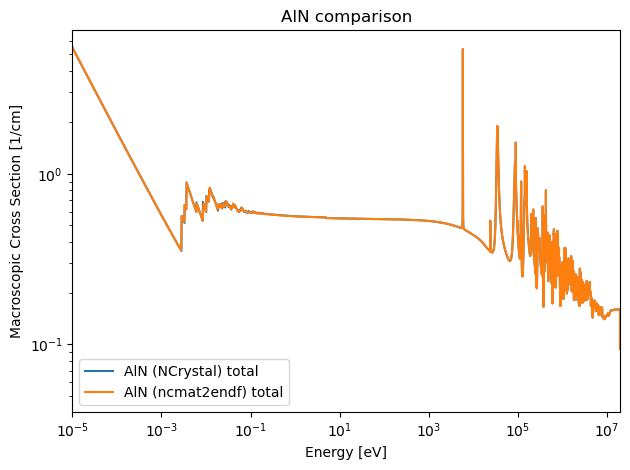

In [13]:
cfg = 'AlN_sg186_AluminumNitride.ncmat;temp=293.6K'
m1 = openmc.Material.from_ncrystal(cfg)
m1.name = 'AlN (NCrystal)'
print(m1)
m2 = convert_openmc_ncrystal_to_ace(cfg, 'AlN', elastic_mode='mixed')
m2.name = 'AlN (ncmat2endf)'
print(m2)

fig = openmc.plot_xs({m1:['total'], m2:['total']})
fig.axes[0].set_title("AlN comparison")

## Use OpenMC to compare on-the-fly and processed libraries


In this example we will calculate the angular distribution from polypropylene in a broomstick problem.

In [14]:
def create_broomstick_model(broomstick_mat, E0=0.95, Emin=0, Emax=20e6,
                            NParticles=1000000, broomstick_diameter=0.001,
                            broomstick_length=10000):
    p1 = openmc.ZPlane(z0=-broomstick_length/2)
    p2 = openmc.ZPlane(z0=+broomstick_length/2)
    c1 = openmc.ZCylinder(r=broomstick_diameter)
    s1 = openmc.Sphere(r=broomstick_length*1.5, boundary_type='vacuum')
    cell1 = openmc.Cell(region=+p1&-p2&-c1, fill=broomstick_mat)
    cell2 = openmc.Cell(region=~(+p1&-p2&-c1)&-s1, fill=None)
    u1 = openmc.Universe(cells=[cell1, cell2])
    geometry = openmc.Geometry(root=u1)

    source = openmc.IndependentSource()
    source.space  = openmc.stats.Point(xyz=[0,0,-broomstick_length/2])
    source.angle  = openmc.stats.Monodirectional(reference_uvw=[0,0,1])
    source.energy = openmc.stats.Discrete([E0], [1.0])

    settings = openmc.Settings()
    settings.source = source
    settings.run_mode = 'fixed source'
    settings.batches = 10
    settings.particles = NParticles
    settings.temperature = {'method':'nearest', 'tolerance':1000}

    tally1 = openmc.Tally()
    filter1 = openmc.SurfaceFilter([c1])
    filter2 = openmc.EnergyFilter([Emin, Emax])
    filter3 = openmc.PolarFilter(np.arccos(np.linspace(1,-1,101)))
    tally1.scores = ['current']
    tally1.name = 'angdist'
    tally1.filters = [filter1, filter2, filter3]
    tallies = openmc.Tallies([tally1])

    return openmc.model.Model(geometry=geometry, settings=settings, tallies=tallies)

In [15]:
cfg = 'Polypropylene_C3H6.ncmat'
material_name = 'Polypropylene'
spfile1, spfile2 = 'results_ncrystal.h5', 'results_ncmat2endf.h5'

m1 = openmc.Material.from_ncrystal(cfg)
print(m1)
n_particles = 5000000
E0 = 0.1  # eV
model = create_broomstick_model(m1, E0=0.95, Emin=0.27, Emax=0.28) # , E0=0.1, Emin=0.05, Emax=0.06)
spfile = model.run(output=True)
import os
os.rename(spfile, spfile1)

m2 = convert_openmc_ncrystal_to_ace(cfg, material_name, elastic_mode='mixed')
print(m2)
model = create_broomstick_model(m2, E0=0.95, Emin=0.27, Emax=0.28) # , E0=0.1, Emin=0.05, Emax=0.06)
spfile = model.run(output=True)
os.rename(spfile, spfile2)

Material
	ID             =	3
	Name           =	
	Temperature    =	293.15
	Density        =	0.855 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	NCrystal conf  =	Polypropylene_C3H6.ncmat
	Nuclides       
	H1             =	0.66656284   [ao]
	H2             =	0.00010382666666666666 [ao]
	C0             =	0.3333333333333333 [ao]

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%

/home/marquezj/anaconda3/envs/ncmat2endf_njoy/lib/python3.12/site-packages/NCrystal/_ncmat2endf_impl.py:1144: NCrystalUserWarning: Temperature not explicitly given in the cfg-string, using T=293.15K
  ncwarn( 'Temperature not explicitly given in the cfg-string,'
/home/marquezj/anaconda3/envs/ncmat2endf_njoy/lib/python3.12/site-packages/NCrystal/_ncmat2endf_impl.py:214: NCrystalUserWarning: ENDF output will not contain a Bragg diffraction component
  ncwarn('ENDF output will not contain a Bragg diffraction'


Initialise nuclear data...


/home/marquezj/anaconda3/envs/ncmat2endf_njoy/lib/python3.12/site-packages/NCrystal/_ncmat2endf_impl.py:469: NCrystalUserWarning: Mixed elastic mode for H but no Bragg edges found: incoherent approximation
  ncwarn(f'Mixed elastic mode for {sym} but no '
/home/marquezj/anaconda3/envs/ncmat2endf_njoy/lib/python3.12/site-packages/NCrystal/_ncmat2endf_impl.py:469: NCrystalUserWarning: Mixed elastic mode for C but no Bragg edges found: incoherent approximation
  ncwarn(f'Mixed elastic mode for {sym} but no '


Write ENDF file tsl_H_in_Polypropylene.endf ...
Write ENDF file tsl_C_in_Polypropylene.endf ...
Files created:
  tsl_H_in_Polypropylene.endf : H with fraction 2/3
  tsl_C_in_Polypropylene.endf : C with fraction 1/3
Suggested material density: 0.855 g/cm^3
Converting tsl_H_in_Polypropylene.endf to c_H_in_Polypropylene-293.1K.ace
Adding c_H_in_Polypropylene to the library...
Generated nndc_hdf5/c_H_in_Polypropylene-293.1K.h5
Converting tsl_C_in_Polypropylene.endf to c_C_in_Polypropylene-293.1K.ace
Adding c_C_in_Polypropylene to the library...
Generated nndc_hdf5/c_C_in_Polypropylene-293.1K.h5
Material
	ID             =	4
	Name           =	
	Temperature    =	293.15
	Density        =	0.855 [g/cc]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_Polypropylene', 1.0)
	S(a,b)         =	('c_C_in_Polypropylene', 1.0)
	Nuclides       
	H1             =	0.66656284   [ao]
	H2             =	0.00010382666666666666 [ao]
	C0             =	0.333333333333

Text(0, 0.5, 'density')

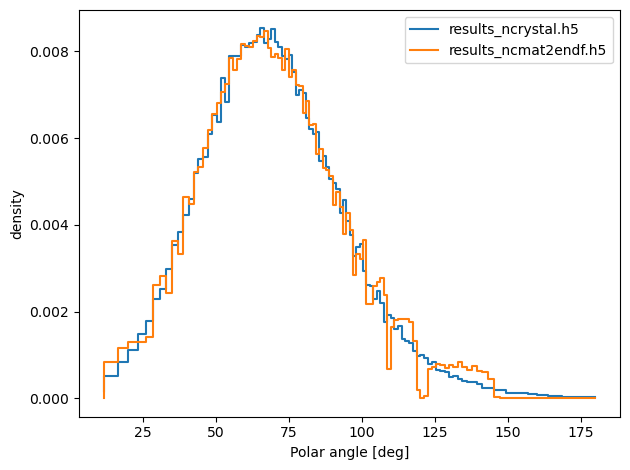

In [16]:
for spfile in (spfile1, spfile2):
  with openmc.StatePoint(spfile) as sp:
    tal = sp.get_tally(name='angdist')
  tal.remove_filter(tal.find_filter(openmc.EnergyFilter))
  df = tal.get_pandas_dataframe()
  bin_high = df['polar high [rad]'].values
  bin_low = df['polar low [rad]'].values
  angdist_values = df['mean'].values/(bin_high - bin_low)
  import matplotlib.pyplot as plt
  plt.step(np.rad2deg(bin_high), angdist_values, label=spfile)
plt.legend()
plt.xlabel('Polar angle [deg]')
plt.ylabel('density')

## Compare the "scaled" and "mixed" approximations for vanadium

In [17]:
def pencil_beam_model(m1, E0, N, Emin=0, Emax=20e6):
    """Return an openmc.Model() object for a monoenergetic pencil
     beam hitting a 1 mm sphere filled with the material m1
     and compute angular distribution for the
     Debye-Scherrer cones"""

    # Material definition
    materials = openmc.Materials([m1])

    # Geometry definition

    sample_sphere = openmc.Sphere(r=0.1)
    outer_sphere = openmc.Sphere(r=100, boundary_type="vacuum")
    cell1 = openmc.Cell(region=-sample_sphere, fill=m1)
    cell2_region = +sample_sphere & -outer_sphere
    cell2 = openmc.Cell(region=cell2_region, fill=None)
    geometry = openmc.Geometry([cell1, cell2])

    # Source definition

    source = openmc.IndependentSource()
    source.space = openmc.stats.Point((0, 0, -20))
    source.angle = openmc.stats.Monodirectional(reference_uvw=(0, 0, 1))
    source.energy = openmc.stats.Discrete([E0], [1.0])

    # Execution settings

    settings = openmc.Settings()
    settings.source = source
    settings.run_mode = "fixed source"
    settings.batches = 10
    settings.particles = N

    # Tally definition

    tally1 = openmc.Tally(name="angular distribution")
    tally1.scores = ["current"]
    filter1 = openmc.SurfaceFilter(sample_sphere)
    filter2 = openmc.PolarFilter(np.linspace(0, np.pi, 180+1))
    filter3 = openmc.CellFromFilter(cell1)
    filter4 = openmc.EnergyFilter([Emin, Emax])
    tally1.filters = [filter1, filter2, filter3, filter4]
    tallies = openmc.Tallies([tally1])

    return openmc.Model(geometry, materials, settings, tallies)

def plot_tallies(spfile1, spfile2, title=None):
    import matplotlib.pyplot as plt
    plt.figure()
    results = {}
    for spfile in [spfile1, spfile2]:
        with openmc.StatePoint(spfile) as sp:
            tal = sp.get_tally(name='angular distribution')
            tal.remove_filter(tal.find_filter(openmc.EnergyFilter))
            df = tal.get_pandas_dataframe()
        bin_high = df['polar high [rad]'].values
        bin_low = df['polar low [rad]'].values
        angdist_values = df['mean'].values/(bin_high - bin_low)

        plt.step(np.rad2deg(bin_high), angdist_values, label=spfile)
        results[spfile] = angdist_values
    plt.yscale('log')
    plt.ylabel('density')
    plt.title(title)
    plt.xlabel('Polar angle [deg]')
    plt.legend()
    plt.show()
    plt.figure()
    plt.step(np.rad2deg(bin_high), results[spfile2]/results[spfile1])
    plt.plot([np.rad2deg(bin_high)[0], np.rad2deg(bin_high)[-1]], [0.5, 0.5], 'k--')
    plt.plot([np.rad2deg(bin_high)[0], np.rad2deg(bin_high)[-1]], [1.5, 1.5], 'k--')
    plt.ylabel('ratio')
    plt.ylim(0, 2)
    plt.title(title)
    plt.xlabel('Polar angle [deg]')
    plt.show()

In [18]:
def compare_ncrystal_ncmat2endf(cfg, material_name, elastic_mode='scaled', E0 = 0.01, title='XS comparison'):
  n_particles = 5000000
  m1 = openmc.Material.from_ncrystal(cfg)
  m1.name = material_name + '(NCrystal)'
  model = pencil_beam_model(m1, E0, n_particles)
  spfile = model.run(output=False)
  import os
  spfile1, spfile2 = 'results_ncrystal.h5', 'results_ncmat2endf.h5'
  os.rename(spfile, spfile1)

  m2 = convert_openmc_ncrystal_to_ace(cfg, material_name, elastic_mode=elastic_mode)
  m2.name = material_name + f'(ncmat2endf - {elastic_mode})'
  model = pencil_beam_model(m2, E0, n_particles)
  spfile = model.run(output=False)
  os.rename(spfile, spfile2)
  plot_tallies(spfile1, spfile2, title=material_name)
  
  fig = openmc.plot_xs({m1:['total'], m2:['total']})
  fig.axes[0].set_title(title)

Initialise nuclear data...
Write ENDF file tsl_V_in_Vanadium.endf ...
Files created:
  tsl_V_in_Vanadium.endf : V with fraction 1
Suggested material density: 6.117939176 g/cm^3
Converting tsl_V_in_Vanadium.endf to c_V_in_Vanadium-293.6K.ace
Adding c_V_in_Vanadium to the library...
Generated nndc_hdf5/c_V_in_Vanadium-293.6K.h5


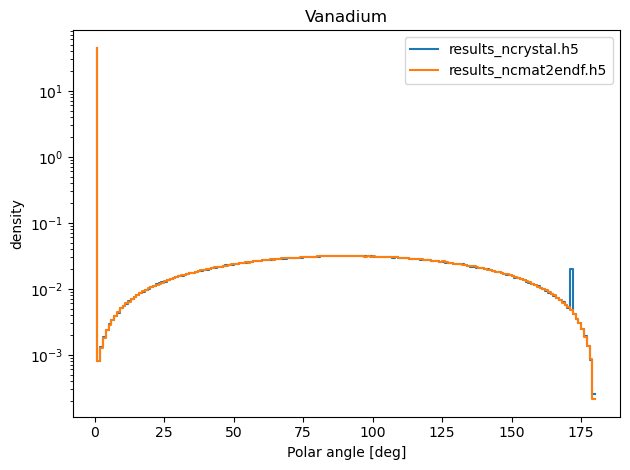

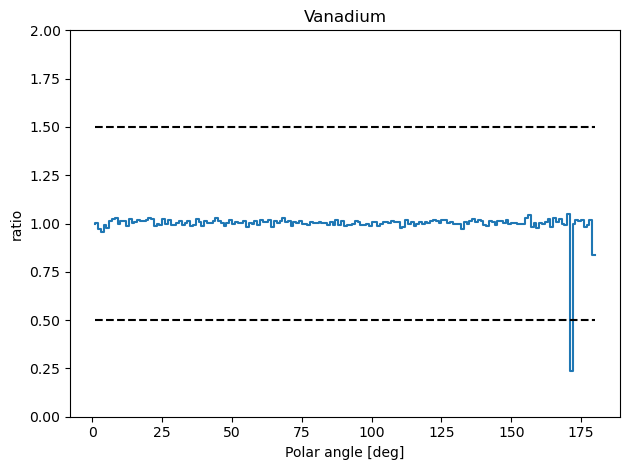

/home/marquezj/anaconda3/envs/ncmat2endf_njoy/lib/python3.12/site-packages/NCrystal/core.py:1276: NCrystalUserWarning: The .crossSectionNonOriented method is deprecated. Please use .crossSectionIsotropic or .xsect methods instead
  warn('The .crossSectionNonOriented method is deprecated.'


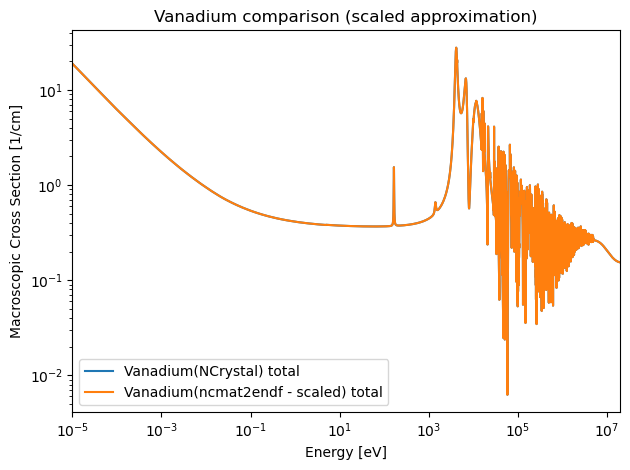

In [19]:
cfg = 'V_sg229.ncmat;temp=293.6K'
material_name = 'Vanadium'
elastic_mode='scaled'
E0 = 0.0045

compare_ncrystal_ncmat2endf(cfg, material_name=material_name, E0=E0,
                            elastic_mode=elastic_mode,
                            title='Vanadium comparison (scaled approximation)' )

Initialise nuclear data...
Write ENDF file tsl_V_in_Vanadium.endf ...
Files created:
  tsl_V_in_Vanadium.endf : V with fraction 1
Suggested material density: 6.117939176 g/cm^3
Converting tsl_V_in_Vanadium.endf to c_V_in_Vanadium-293.6K.ace
Adding c_V_in_Vanadium to the library...
Generated nndc_hdf5/c_V_in_Vanadium-293.6K.h5


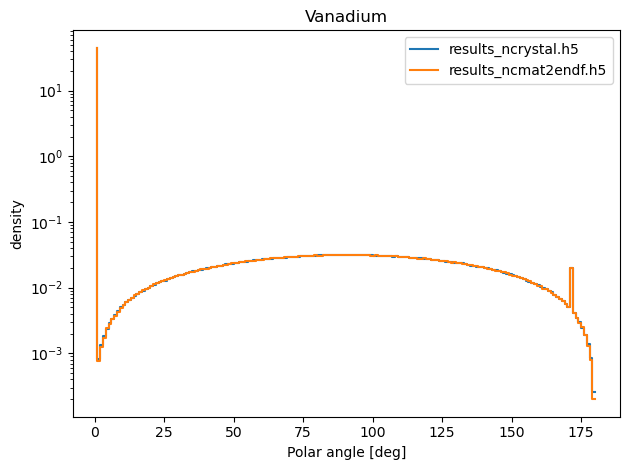

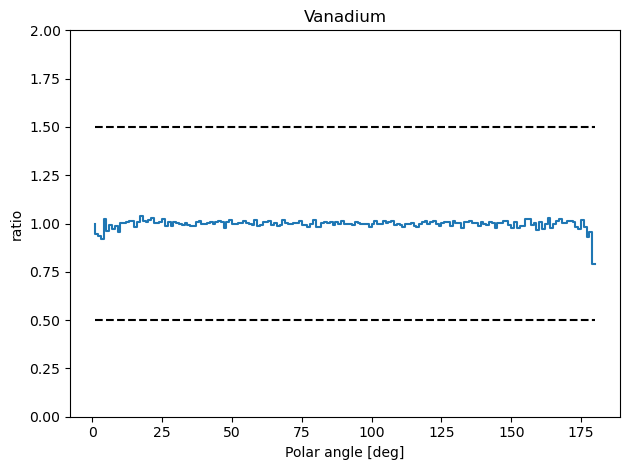

/home/marquezj/anaconda3/envs/ncmat2endf_njoy/lib/python3.12/site-packages/NCrystal/core.py:1276: NCrystalUserWarning: The .crossSectionNonOriented method is deprecated. Please use .crossSectionIsotropic or .xsect methods instead
  warn('The .crossSectionNonOriented method is deprecated.'


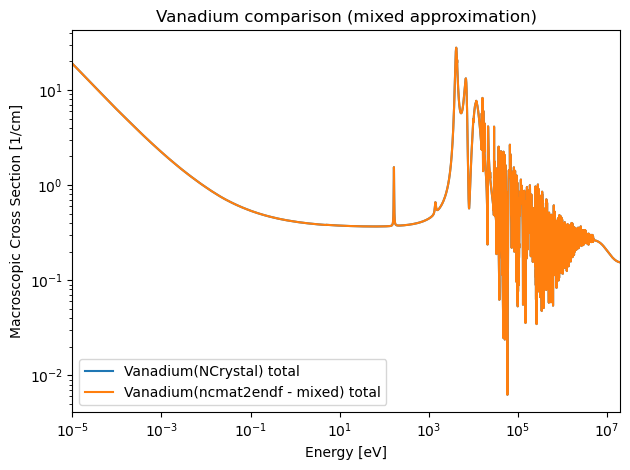

In [21]:
cfg = 'V_sg229.ncmat;temp=293.6K'
material_name = 'Vanadium'
elastic_mode='mixed'

compare_ncrystal_ncmat2endf(cfg, material_name=material_name, E0=E0,
                            elastic_mode=elastic_mode,
                            title='Vanadium comparison (mixed approximation)' )

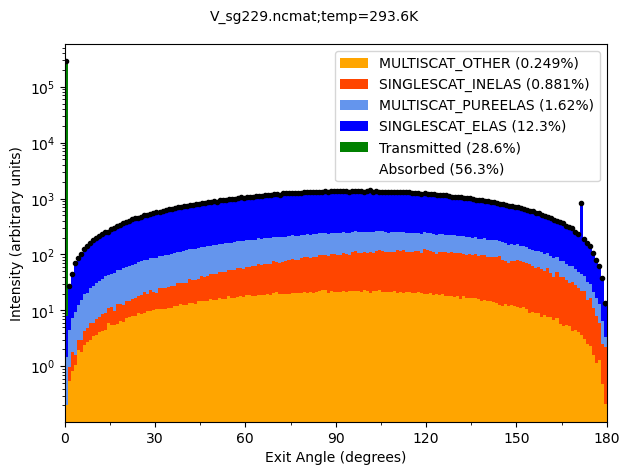

In [22]:
import NCrystal._mmc as ncmmc
pattern = ncmmc.quick_diffraction_pattern(cfg,
                                           neutron_energy = f'{E0}eV',
                                           material_thickness = '1cm')

pattern.plot_breakdown(rebin_factor=10,logy=True)

## Compare a simulation for Bismuth Germanate

Initialise nuclear data...
Write ENDF file tsl_O_in_BGO.endf ...
Write ENDF file tsl_Ge_in_BGO.endf ...
Write ENDF file tsl_Bi_in_BGO.endf ...
Files created:
  tsl_O_in_BGO.endf : O with fraction 12/19
  tsl_Ge_in_BGO.endf : Ge with fraction 3/19
  tsl_Bi_in_BGO.endf : Bi with fraction 4/19
Suggested material density: 7.099346529 g/cm^3
Converting tsl_O_in_BGO.endf to c_O_in_BGO-293.6K.ace
Adding c_O_in_BGO to the library...
Generated nndc_hdf5/c_O_in_BGO-293.6K.h5
Converting tsl_Ge_in_BGO.endf to c_Ge_in_BGO-293.6K.ace
Adding c_Ge_in_BGO to the library...
Generated nndc_hdf5/c_Ge_in_BGO-293.6K.h5
Converting tsl_Bi_in_BGO.endf to c_Bi_in_BGO-293.6K.ace
Adding c_Bi_in_BGO to the library...
Generated nndc_hdf5/c_Bi_in_BGO-293.6K.h5


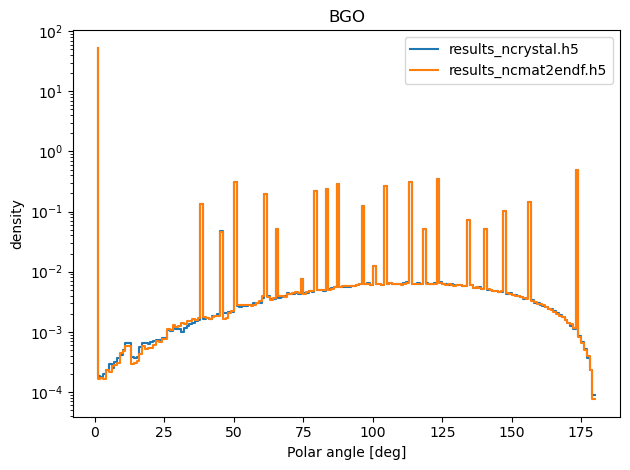

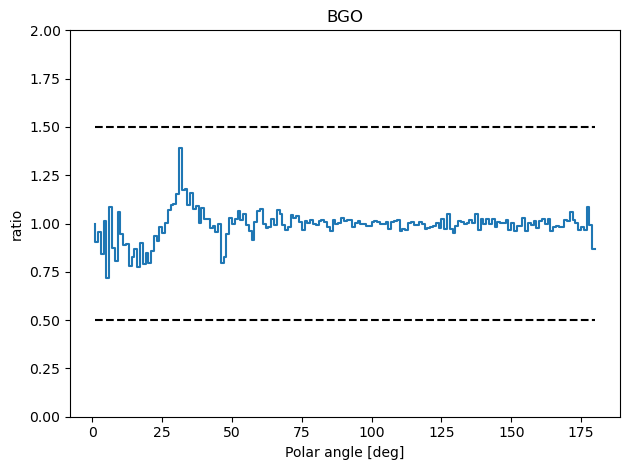

/home/marquezj/anaconda3/envs/ncmat2endf_njoy/lib/python3.12/site-packages/NCrystal/core.py:1276: NCrystalUserWarning: The .crossSectionNonOriented method is deprecated. Please use .crossSectionIsotropic or .xsect methods instead
  warn('The .crossSectionNonOriented method is deprecated.'


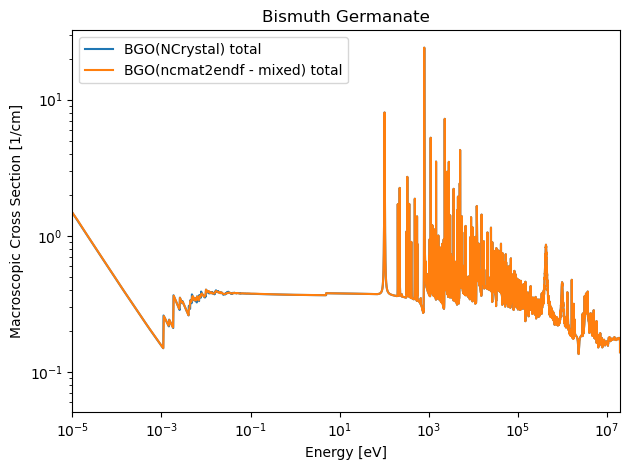

In [23]:
cfg = 'Ge3Bi4O12_sg220_BismuthGermanate.ncmat;temp=293.6K'
material_name = 'BGO'
elastic_mode='mixed'
compare_ncrystal_ncmat2endf(cfg, material_name, elastic_mode=elastic_mode, title='Bismuth Germanate')